In [1]:
import time
import copy
import numpy as np
from skimage.filters import gaussian
import cv2 

import matplotlib.pyplot as plt
import pylab as pl

%matplotlib inline
%pylab inline
pylab.rcParams['figure.figsize'] = (15, 10)

from tifffile import imread, imsave
import pickle

%reload_ext autoreload
%autoreload 2

from netsurface2d import NetSurf2d
from netsurface2dt import NetSurf2dt
from data3d import Data3d
import bresenham as bham
import bobsegutils as bsu

from shapely import geometry
from shapely.geometry import Point
from shapely.geometry.polygon import Polygon

from scipy.interpolate import griddata

from scipy.stats.stats import pearsonr
from scipy.stats.stats import kendalltau

Populating the interactive namespace from numpy and matplotlib


/Users/jug/local/miniconda3/envs/BobSeg/lib/python2.7/site-packages/IPython/core/magics/pylab.py:161: UserWarning: pylab import has clobbered these variables: ['copy']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


# Loading and preparing data

```stack``` is the original stack as it is loaded from file<br>
```segchannel``` is the membrane channel only (needs to be taken out of loaded stack)<br>
```flowchannel``` is the myosin channel only<br>
```segchannel_smooth``` is the ```segchannel``` after gaussian smoothing<br>
(note: the less the better for the gradientimage)<br>
```gradientimage``` should be used for segmentation if some of the cell boundary (membrane) is barely visible<br>

In [2]:
np.gradient?

In [3]:
# filename = '/Users/jug/Repositories/GIT/BobSeg/data/ProjectGoldstein/4MyosinMembraneWholeEmbryo.tif'
filename = '/Users/jug/Repositories/GIT/BobSeg/data/ProjectGoldstein/MAX_mNG-mSc_04_MEDIUM_UNCOUPLED.tif'
# filename = '/Users/jug/Repositories/GIT/BobSeg/data/ProjectGoldstein/MAX_mNG-mSc_05_MEDIUM_COUPLED.tif'

stack = imread(filename)
segchannel = stack[:,1,:,:]
flowchannel = stack[:,0,:,:]

sigma = [0.,2,2]
segchannel_smooth = gaussian(segchannel,sigma)

gx = np.gradient(segchannel_smooth, 25, axis=2)
gy = np.gradient(segchannel_smooth, 25, axis=1)
gx = np.abs(gx)
gy = np.abs(gy)
gradientimage = gx+gy                  # add x and y gradients
gradientimage /= np.max(gradientimage) # normalizes such that largest value is 1.0
gradientimage **= .5                   # emphasizes smaller gradient values
gradientimage = gaussian(gradientimage,sigma)

print('Shape of stack:', stack.shape)
print('Shape of flow channel:', flowchannel.shape)

('Shape of stack:', (61, 2, 545, 833))
('Shape of flow channel:', (61, 545, 833))


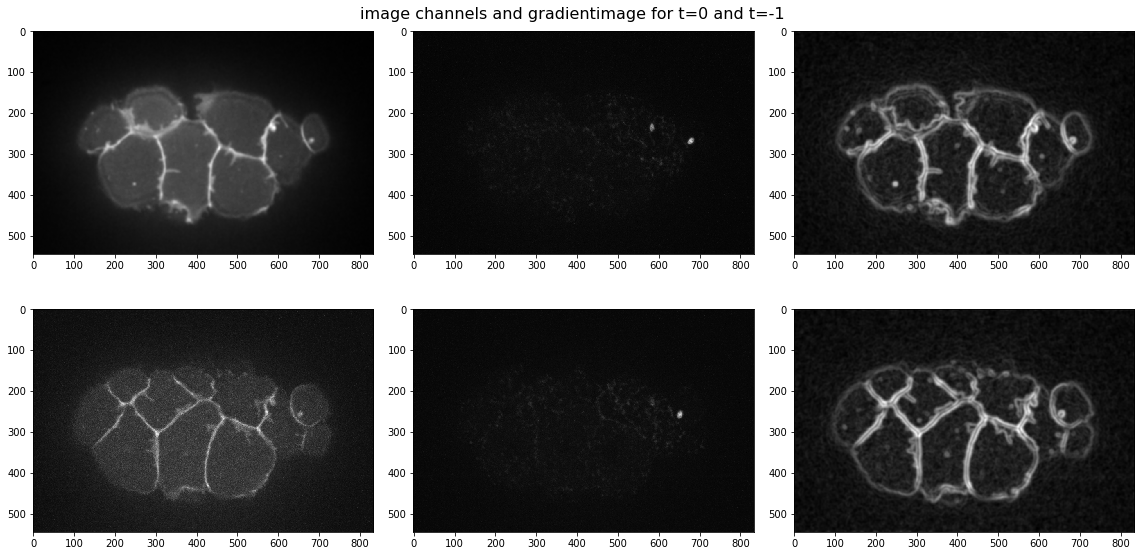

In [4]:
pylab.rcParams['figure.figsize'] = (16, 8)
fig = plt.figure()
fig.suptitle('image channels and gradientimage for t=0 and t=-1', fontsize=16)
ax = fig.add_subplot(231)
ax.imshow(segchannel_smooth[0], plt.get_cmap('gray'))
ax = fig.add_subplot(232)
ax.imshow(flowchannel[0], plt.get_cmap('gray'))
ax = fig.add_subplot(233)
ax.imshow(gradientimage[0], plt.get_cmap('gray'))
ax = fig.add_subplot(234)
ax.imshow(segchannel[-1], plt.get_cmap('gray'))
ax = fig.add_subplot(235)
ax.imshow(flowchannel[-1], plt.get_cmap('gray'))
ax = fig.add_subplot(236)
ax.imshow(gradientimage[-1], plt.get_cmap('gray'))
fig.tight_layout()

# Flow computation

In [5]:
flows = bsu.compute_flow( flowchannel )
flow_x, flow_y = bsu.split_flow_components( flows )

............................................................. ...done!


In [6]:
avg_flow_x = bsu.flow_average(flow_x, 5)
avg_flow_y = bsu.flow_average(flow_y, 5)

# Cell segmentation

In [7]:
# defining min and max radius for cell segmentation
max_rs = ((segchannel[0].shape[1] / 6),
          (segchannel[0].shape[1] / 6))

min_rs = (10,10)
print (min_rs, max_rs)

((10, 10), (138, 138))


In [8]:
data = Data3d( gradientimage, pixelsize=(1.,1.), silent=False )
data.set_seg_params(num_columns=72,K=100,max_delta_k=4)
objects = []

In [9]:
cell_Ea = data.init_object("Ea")
objects.append(cell_Ea)
data.add_object_at( cell_Ea, min_rs, max_rs, frame=0, seed=(520,225), segment_it=False )
moving_center_Ea = data.track(cell_Ea, seed_frame=0, target_frames=range(1,len(data.images)), recenter_iterations=1)

('Added appearance for "Ea" in frame', 0, 'with seed coordinates', array([520., 225.]))
('Added appearance for "Ea" in frame', 1, 'with seed coordinates', array([520., 225.]))
('      Optimum energy: ', 22.08273496175117)
('      Nodes in/out: ', 3973, 3227)
('      Area: ', 19945.000000000004)
('    Updated center to', array([511, 220]))
('Added appearance for "Ea" in frame', 2, 'with seed coordinates', array([511., 220.]))
('      Optimum energy: ', 23.28685260702291)
('      Nodes in/out: ', 4085, 3115)
('      Area: ', 20701.000000000004)
('    Updated center to', array([506, 216]))
('Added appearance for "Ea" in frame', 3, 'with seed coordinates', array([506., 216.]))
('      Optimum energy: ', 22.490281690555747)
('      Nodes in/out: ', 4092, 3108)
('      Area: ', 20637.99999999999)
('    Updated center to', array([506, 215]))
('Added appearance for "Ea" in frame', 4, 'with seed coordinates', array([506., 215.]))
('      Optimum energy: ', 22.200616476613984)
('      Nodes in/o

('      Nodes in/out: ', 2895, 4305)
('      Area: ', 11148.999999999996)
('    Updated center to', array([515, 219]))
('Added appearance for "Ea" in frame', 35, 'with seed coordinates', array([515., 219.]))
('      Optimum energy: ', 24.134591736142244)
('      Nodes in/out: ', 2909, 4291)
('      Area: ', 11197.999999999995)
('    Updated center to', array([516, 219]))
('Added appearance for "Ea" in frame', 36, 'with seed coordinates', array([516., 219.]))
('      Optimum energy: ', 24.049405679472045)
('      Nodes in/out: ', 2956, 4244)
('      Area: ', 11490.999999999993)
('    Updated center to', array([516, 218]))
('Added appearance for "Ea" in frame', 37, 'with seed coordinates', array([516., 218.]))
('      Optimum energy: ', 23.398137992678468)
('      Nodes in/out: ', 2857, 4343)
('      Area: ', 10849.500000000002)
('    Updated center to', array([517, 219]))
('Added appearance for "Ea" in frame', 38, 'with seed coordinates', array([517., 219.]))
('      Optimum energy: ', 

In [10]:
cell_Ep = data.init_object("Ep")
objects.append(cell_Ep)
data.add_object_at( cell_Ep, min_rs, max_rs, frame=0, seed=(620,275), segment_it=False )
moving_center_Ep = data.track(cell_Ep, seed_frame=0, target_frames=range(1,len(data.images)), recenter_iterations=1)

('Added appearance for "Ep" in frame', 0, 'with seed coordinates', array([620., 275.]))
('Added appearance for "Ep" in frame', 1, 'with seed coordinates', array([620., 275.]))
('      Optimum energy: ', 21.836400530041463)
('      Nodes in/out: ', 3136, 4064)
('      Area: ', 13350.499999999995)
('    Updated center to', array([617, 280]))
('Added appearance for "Ep" in frame', 2, 'with seed coordinates', array([617., 280.]))
('      Optimum energy: ', 21.437241982432962)
('      Nodes in/out: ', 3186, 4014)
('      Area: ', 13432.0)
('    Updated center to', array([618, 282]))
('Added appearance for "Ep" in frame', 3, 'with seed coordinates', array([618., 282.]))
('      Optimum energy: ', 22.275800894964625)
('      Nodes in/out: ', 3292, 3908)
('      Area: ', 14489.000000000004)
('    Updated center to', array([617, 286]))
('Added appearance for "Ep" in frame', 4, 'with seed coordinates', array([617., 286.]))
('      Optimum energy: ', 22.67148320550727)
('      Nodes in/out: ', 33

('      Optimum energy: ', 23.2412703663636)
('      Nodes in/out: ', 2860, 4340)
('      Area: ', 11227.999999999996)
('    Updated center to', array([611, 273]))
('Added appearance for "Ep" in frame', 36, 'with seed coordinates', array([611., 273.]))
('      Optimum energy: ', 23.269957375718633)
('      Nodes in/out: ', 2696, 4504)
('      Area: ', 10106.000000000004)
('    Updated center to', array([609, 271]))
('Added appearance for "Ep" in frame', 37, 'with seed coordinates', array([609., 271.]))
('      Optimum energy: ', 22.036284680540703)
('      Nodes in/out: ', 2634, 4566)
('      Area: ', 9691.499999999996)
('    Updated center to', array([608, 269]))
('Added appearance for "Ep" in frame', 38, 'with seed coordinates', array([608., 269.]))
('      Optimum energy: ', 21.959403138609975)
('      Nodes in/out: ', 2570, 4630)
('      Area: ', 9381.500000000005)
('    Updated center to', array([606, 267]))
('Added appearance for "Ep" in frame', 39, 'with seed coordinates', array

In [11]:
surface_coords_Ea, surface_coords_interior1_Ea, surface_coords_interior_last_Ea = data.segment2dt( cell_Ea, max_radial_delta=2 )

('Surface points:', [(588, 225), (588, 231), (587, 236), (581, 241), (575, 245), (573, 249), (575, 256), (576, 264), (576, 272), (575, 280), (574, 289), (571, 298), (567, 306), (558, 308), (549, 306), (541, 305), (533, 302), (526, 301), (520, 299), (513, 297), (507, 296), (501, 294), (495, 292), (490, 287), (486, 283), (480, 281), (475, 277), (471, 273), (468, 268), (464, 263), (460, 259), (454, 255), (450, 250), (443, 245), (437, 239), (430, 232), (425, 225), (423, 216), (425, 208), (425, 199), (427, 191), (427, 181), (427, 171), (427, 160), (436, 155), (446, 151), (456, 149), (466, 148), (475, 148), (484, 149), (492, 148), (499, 148), (506, 150), (513, 152), (520, 154), (526, 156), (531, 158), (537, 159), (544, 157), (549, 161), (556, 162), (562, 164), (569, 166), (574, 170), (579, 174), (581, 181), (586, 186), (589, 192), (596, 197), (601, 203), (597, 211), (593, 218)])
('Interior points:', [(577, 225), (577, 229), (576, 234), (570, 238), (564, 241), (562, 244), (565, 251), (566, 25

('Surface points:', [(579, 221), (578, 226), (573, 230), (572, 235), (570, 240), (569, 245), (568, 250), (567, 255), (565, 261), (563, 266), (562, 273), (560, 281), (557, 289), (553, 297), (545, 296), (537, 293), (530, 290), (523, 287), (518, 284), (512, 284), (507, 282), (502, 278), (498, 274), (494, 271), (489, 270), (485, 267), (482, 262), (479, 259), (475, 257), (471, 253), (468, 249), (466, 245), (462, 241), (457, 237), (451, 232), (445, 227), (440, 221), (444, 214), (445, 208), (450, 202), (454, 197), (461, 194), (463, 189), (466, 185), (474, 184), (477, 180), (480, 176), (486, 176), (490, 173), (495, 172), (500, 171), (504, 170), (508, 169), (513, 167), (518, 166), (522, 166), (527, 164), (533, 164), (539, 162), (545, 162), (552, 161), (558, 162), (565, 164), (570, 168), (575, 172), (580, 177), (586, 181), (587, 188), (586, 196), (584, 203), (583, 209), (581, 215)])
('Interior points:', [(567, 221), (567, 225), (561, 228), (561, 232), (559, 236), (559, 240), (558, 244), (557, 24

('Surface points:', [(579, 212), (575, 217), (572, 222), (571, 227), (573, 234), (566, 237), (567, 243), (566, 250), (560, 252), (559, 259), (558, 267), (556, 275), (552, 281), (546, 286), (539, 288), (532, 287), (524, 283), (518, 281), (512, 278), (506, 275), (501, 271), (497, 266), (492, 264), (487, 263), (480, 266), (473, 267), (471, 260), (467, 256), (467, 249), (466, 244), (464, 239), (461, 235), (454, 232), (447, 229), (441, 224), (435, 218), (435, 212), (438, 205), (440, 199), (440, 192), (440, 185), (446, 181), (449, 175), (453, 171), (456, 165), (464, 164), (468, 160), (472, 155), (480, 156), (487, 158), (493, 161), (498, 160), (502, 158), (507, 157), (512, 153), (517, 153), (521, 155), (527, 155), (532, 156), (537, 157), (543, 156), (548, 159), (555, 160), (561, 162), (568, 164), (573, 168), (577, 174), (580, 180), (582, 186), (584, 192), (586, 198), (584, 205)])
('Interior points:', [(568, 212), (564, 216), (560, 220), (559, 224), (562, 230), (555, 232), (557, 238), (556, 24

In [12]:
surface_coords_Ep, surface_coords_interior1_Ep, surface_coords_interior_last_Ep = data.segment2dt( cell_Ep, max_radial_delta=2 )

('Surface points:', [(663, 275), (666, 279), (671, 284), (674, 289), (677, 295), (678, 302), (677, 308), (673, 312), (670, 317), (669, 324), (665, 329), (663, 336), (660, 344), (655, 351), (650, 358), (644, 365), (636, 370), (628, 372), (620, 374), (611, 370), (604, 364), (597, 357), (592, 350), (588, 343), (584, 335), (581, 329), (578, 324), (574, 320), (572, 315), (570, 309), (569, 304), (564, 300), (567, 294), (570, 288), (571, 283), (571, 279), (571, 275), (571, 270), (571, 266), (572, 262), (570, 257), (568, 250), (568, 245), (569, 239), (572, 234), (575, 230), (579, 227), (581, 220), (585, 215), (589, 210), (594, 205), (600, 201), (607, 202), (613, 200), (620, 204), (626, 206), (631, 212), (636, 212), (640, 218), (644, 221), (648, 225), (653, 226), (654, 234), (654, 240), (658, 243), (658, 247), (659, 252), (660, 256), (661, 259), (663, 263), (658, 268), (661, 271)])
('Interior points:', [(651, 275), (655, 278), (660, 282), (663, 286), (666, 291), (668, 297), (667, 302), (663, 30

('Surface points:', [(664, 281), (669, 285), (673, 290), (677, 297), (680, 304), (682, 311), (681, 318), (679, 324), (675, 330), (668, 332), (664, 337), (659, 341), (653, 343), (648, 348), (642, 351), (636, 353), (630, 358), (623, 354), (617, 352), (610, 350), (604, 352), (599, 347), (595, 340), (592, 334), (588, 330), (585, 325), (584, 320), (581, 316), (577, 313), (575, 310), (570, 307), (566, 304), (559, 301), (560, 296), (561, 290), (563, 285), (564, 281), (566, 276), (566, 272), (567, 267), (569, 263), (571, 260), (572, 255), (574, 251), (575, 245), (576, 240), (576, 233), (578, 225), (580, 218), (584, 210), (588, 203), (594, 195), (600, 189), (608, 186), (617, 191), (624, 195), (631, 198), (637, 203), (642, 210), (647, 216), (650, 223), (652, 230), (653, 238), (653, 244), (655, 249), (654, 254), (652, 260), (652, 264), (654, 267), (655, 270), (657, 273), (660, 277)])
('Interior points:', [(652, 281), (657, 284), (662, 288), (666, 294), (669, 300), (672, 306), (671, 312), (670, 31

('Surface points:', [(652, 277), (657, 281), (662, 286), (666, 292), (663, 297), (660, 301), (657, 306), (658, 312), (658, 320), (658, 328), (657, 336), (654, 344), (651, 353), (642, 352), (635, 354), (627, 352), (620, 353), (613, 355), (607, 352), (600, 348), (595, 342), (591, 336), (587, 329), (585, 323), (583, 317), (581, 313), (579, 310), (577, 306), (571, 306), (568, 304), (565, 301), (560, 298), (556, 295), (557, 290), (551, 286), (556, 281), (557, 277), (561, 273), (561, 269), (562, 265), (563, 261), (563, 256), (562, 251), (569, 250), (568, 245), (570, 240), (570, 233), (571, 225), (573, 218), (577, 214), (581, 207), (587, 203), (592, 196), (600, 200), (607, 201), (613, 204), (619, 205), (624, 211), (628, 218), (631, 225), (633, 231), (634, 238), (633, 244), (634, 249), (636, 252), (637, 255), (640, 257), (640, 261), (641, 264), (643, 267), (645, 270), (648, 273)])
('Interior points:', [(641, 277), (646, 280), (650, 284), (654, 289), (652, 293), (649, 296), (647, 300), (648, 30

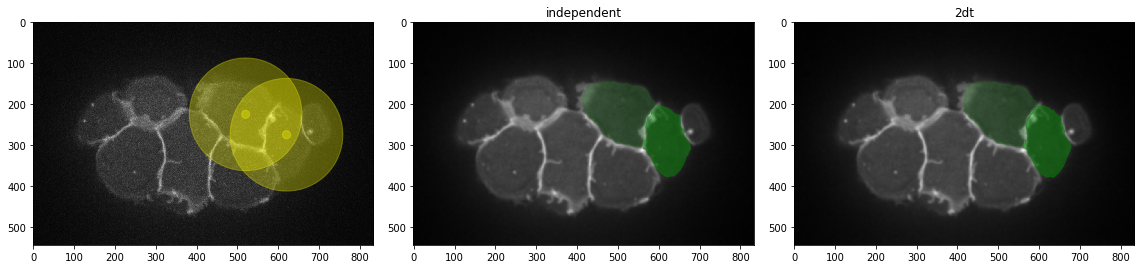

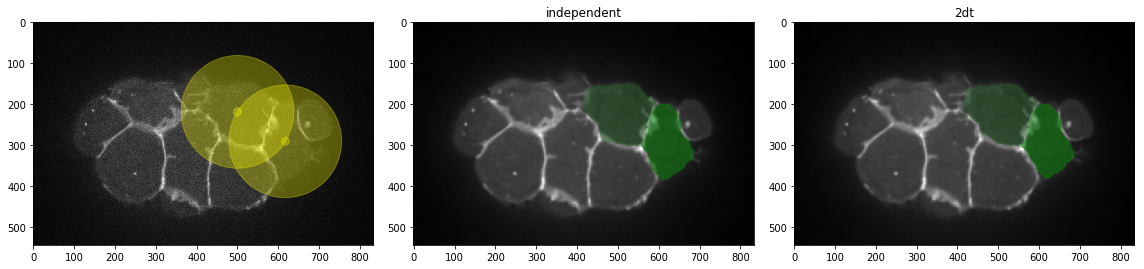

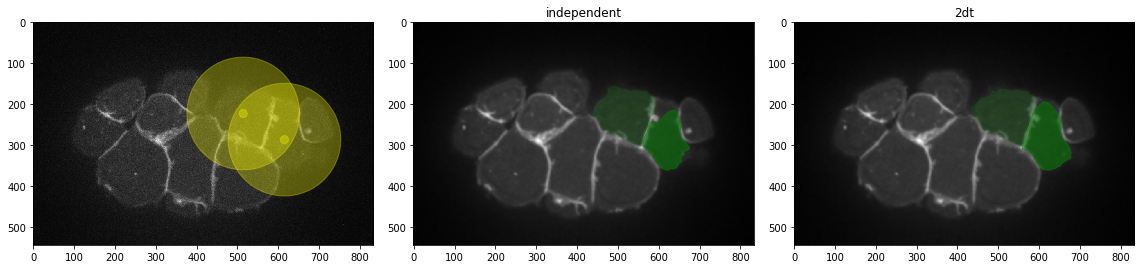

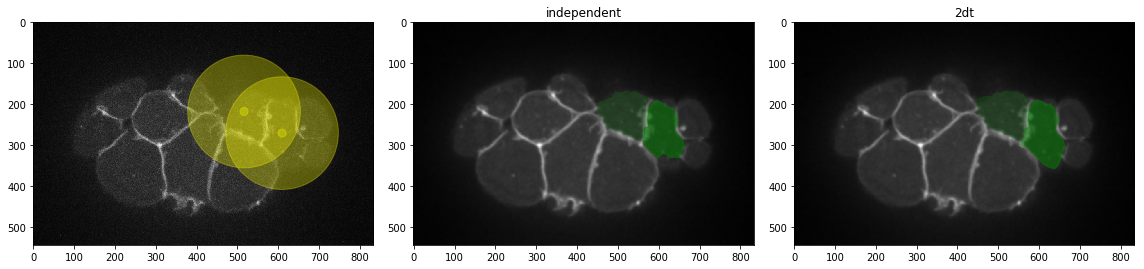

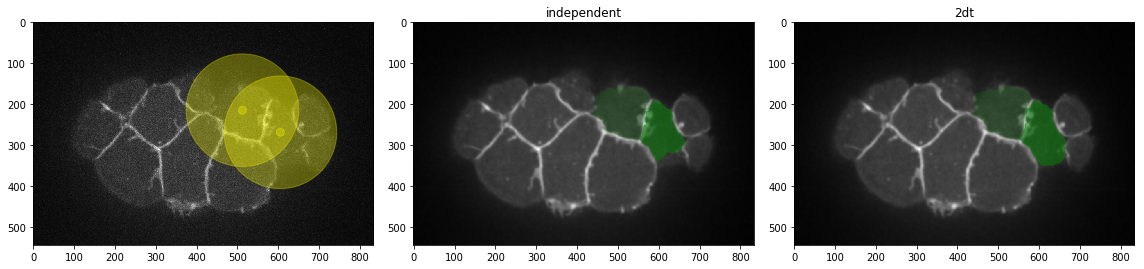

In [13]:
pylab.rcParams['figure.figsize'] = (16, 10)
for frame in range(1,len(data.images),len(data.images)/5):
    fig = plt.figure()
    ax = plt.subplot(131)
    data.plot_minmax( frame, ax, segchannel )
    ax = plt.subplot(132)
    ax.set_title('independent')
    data.plot_result( frame, ax, segchannel_smooth )    
    ax = plt.subplot(133)
    ax.set_title('2dt')
    data.plot_2dt_result( frame, ax, segchannel_smooth )
    fig.tight_layout()